# Cybersecurity Graph Analytics with xGT on HPE Superdome Flex
  
 ## Lateral Movement
 --- 
*Lateral movement* is a cyberattack pattern that describes how an adversary leverages a single foothold to compromise other systems within a network. Identifying and stopping lateral movement is an important step in controlling the damage from a breach, and also plays a role in forensic analysis of a cyberatt ack, helping to identify its source and reconstruct what happened.  

## Lateral Movement (Pass The Hash)
---
Pass the hash (PtH) is a method of authenticating as a user without having access to the user's cleartext password. This method bypasses standard authentication steps that require a cleartext password, moving directly into the portion of the authentication that uses the password hash.

### Event ID's Meaning <br>
    1.4688 - Process Execution in windows
    
### Details associated with Pass the Hash attack
| Malware | TECHNIQUE | O/S | Windows Event Id | Windows Port | Process | DLL | Other Parameters
| --- | --- | --- | --- | --- | --- | --- | --- |
| SoftCell/Empire | T1075 | Windows | 4688 | 135/445 |  |  | Authentication Package = ‘NTLM’ |

### Pass the Hash Attack Flow
    1.Windows uses lsass to maintain the users password hashes in memory. Tools like mimikatz can dump these hashes from memory.
    2.These hashes can be used to authenticate as legitimate users.
    3.Soft cell uses these hashes along with PsExec(445) or WMI(135) for lateral movement

In this notebook, we show how Cybersecurity Graph Analytics can be implemented with xGT on HPE Superdome Flex for  large data.

Mitre Attack Catalog https://attack.mitre.org/

Dataset : https://datasets.trovares.com/cyber/LANL/ind	

In [1]:
from neo4j import GraphDatabase
import time

In [2]:
# Get Connection to neo4j

uri = 'bolt://localhost:7687'
username = 'neo4j'
password = 'graph'

neo4j_driver = GraphDatabase.driver(uri, auth=(username,password))

In [ ]:
# DATA IS LOADED USING neo4j-import

#Netflow = "LOAD CSV WITH HEADERS FROM 'file:///nf_200.csv' AS row MERGE (m:Devices {Name:row.src_device}) MERGE (n:Devices {Name:row.dst_device}) MERGE (m) -[:Netflow { epoch_time:toInteger(row.epoch_time), duration:toInteger(row.duration), protocol:toInteger(row.protocol), src_port:toInteger(row.src_port), dst_port:toInteger(row.dst_port), src_packets:toInteger(row.src_packets), dst_packets:toInteger(row.dst_packets), src_bytes:toInteger(row.src_bytes), dst_bytes:toInteger(row.dst_bytes) }]-> (n)"

#start = time.time()
#with neo4j_driver.session() as neo4j_Session:
#    neo4j_Session.run(Netflow)

In [ ]:
# DATA IS LOADED USING neo4j-import


#HostEvents = "LOAD CSV WITH HEADERS FROM 'file:///1v_200.csv' AS row MERGE (m:Devices {Name:row.log_host}) MERGE (m) -[:HostEvents { epoch_time:toInteger(row.epoch_time),event_id:toInteger(row.event_id),user_name:row.user_name, domain_name:row.domain_name, logon_id: toInteger(row.logon_id), process_name:row.process_name, process_id:toInteger(row.process_id), parent_process_name:row.parent_process_name, parent_process_id:toInteger(row.parent_process_id) }]-> (m)" 
                         
#start = time.time()
#with neo4j_driver.session() as neo4j_Session:
#    neo4j_Session.run(HostEvents)

In [3]:
# filtering with port no. 135 & 445.
# If NetFlow edge has dst_port=135 or 445 then Create LMFlow edge between those nodes.
# These are the ports used by Empire/SoftCell malware for Lateral Movement.


Port_Query = """MATCH (v0:Devices)-[edge:Netflow]->(v1:Devices) 
WHERE edge.dst_port=135 OR edge.dst_port=445 
CREATE (v0)-[e:LMFlow 
             {epoch_time : toInteger(edge.epoch_time), duration : toInteger(edge.duration), 
              protocol : toInteger(edge.protocol), src_port : toInteger(edge.src_port), 
              dst_port : toInteger(edge.dst_port)}]->(v1) RETURN count(*)"""


with neo4j_driver.session() as neo4j_Session:
    result1 = neo4j_Session.run(Port_Query)

print(result1.data())

[{'count(*)': 5210584}]


In [47]:
# Lateral Movement after executing lsass process using port 135 or 445.

hop_threshold = 180
LMflow_Query = """MATCH (A:Devices)-[r1:LMFlow]->(B:Devices) 
MATCH (A)-[hijack1:HostEvents]->(A) 
WHERE A <> B AND hijack1.event_id = 4688 
AND hijack1.parent_process_name = 'lsass' 
AND hijack1.epoch_time <= r1.epoch_time 
AND r1.epoch_time - hijack1.epoch_time < {0} 
AND r1.duration < 300
RETURN A.src, B.src, r1.epoch_time, hijack1.epoch_time, r1.duration""".format(hop_threshold)


with neo4j_driver.session() as neo4j_Session:
    result2 = neo4j_Session.run(LMflow_Query)


In [48]:
import pandas as pd

df = pd.DataFrame(result2.data())

df.head()

,A.src,B.src,r1.epoch_time,hijack1.epoch_time,r1.duration
0,Comp921148,ActiveDirectory,7290283,7290114,6
1,Comp921148,ActiveDirectory,7290248,7290114,2
2,Comp921148,ActiveDirectory,7290127,7290114,6
3,Comp921148,ActiveDirectory,7290194,7290114,1
4,Comp921148,ActiveDirectory,7290235,7290114,6


In [49]:
df_plot = df[0:10]
df_plot

,A.src,B.src,r1.epoch_time,hijack1.epoch_time,r1.duration
0,Comp921148,ActiveDirectory,7290283,7290114,6
1,Comp921148,ActiveDirectory,7290248,7290114,2
2,Comp921148,ActiveDirectory,7290127,7290114,6
3,Comp921148,ActiveDirectory,7290194,7290114,1
4,Comp921148,ActiveDirectory,7290235,7290114,6
5,Comp921148,ActiveDirectory,7290146,7290114,1
6,Comp921148,ActiveDirectory,7290208,7290114,6
7,Comp921148,ActiveDirectory,7290263,7290114,6
8,Comp921148,ActiveDirectory,7290119,7290114,7
9,Comp921148,ActiveDirectory,7290201,7290114,1


In [50]:
import networkx as nx
import matplotlib.pyplot as plt

attr = ["r1.epoch_time","hijack1.epoch_time","r1.duration"]
G=nx.from_pandas_edgelist(df, source='A.src', target='B.src', edge_attr=attr, create_using=nx.MultiDiGraph())


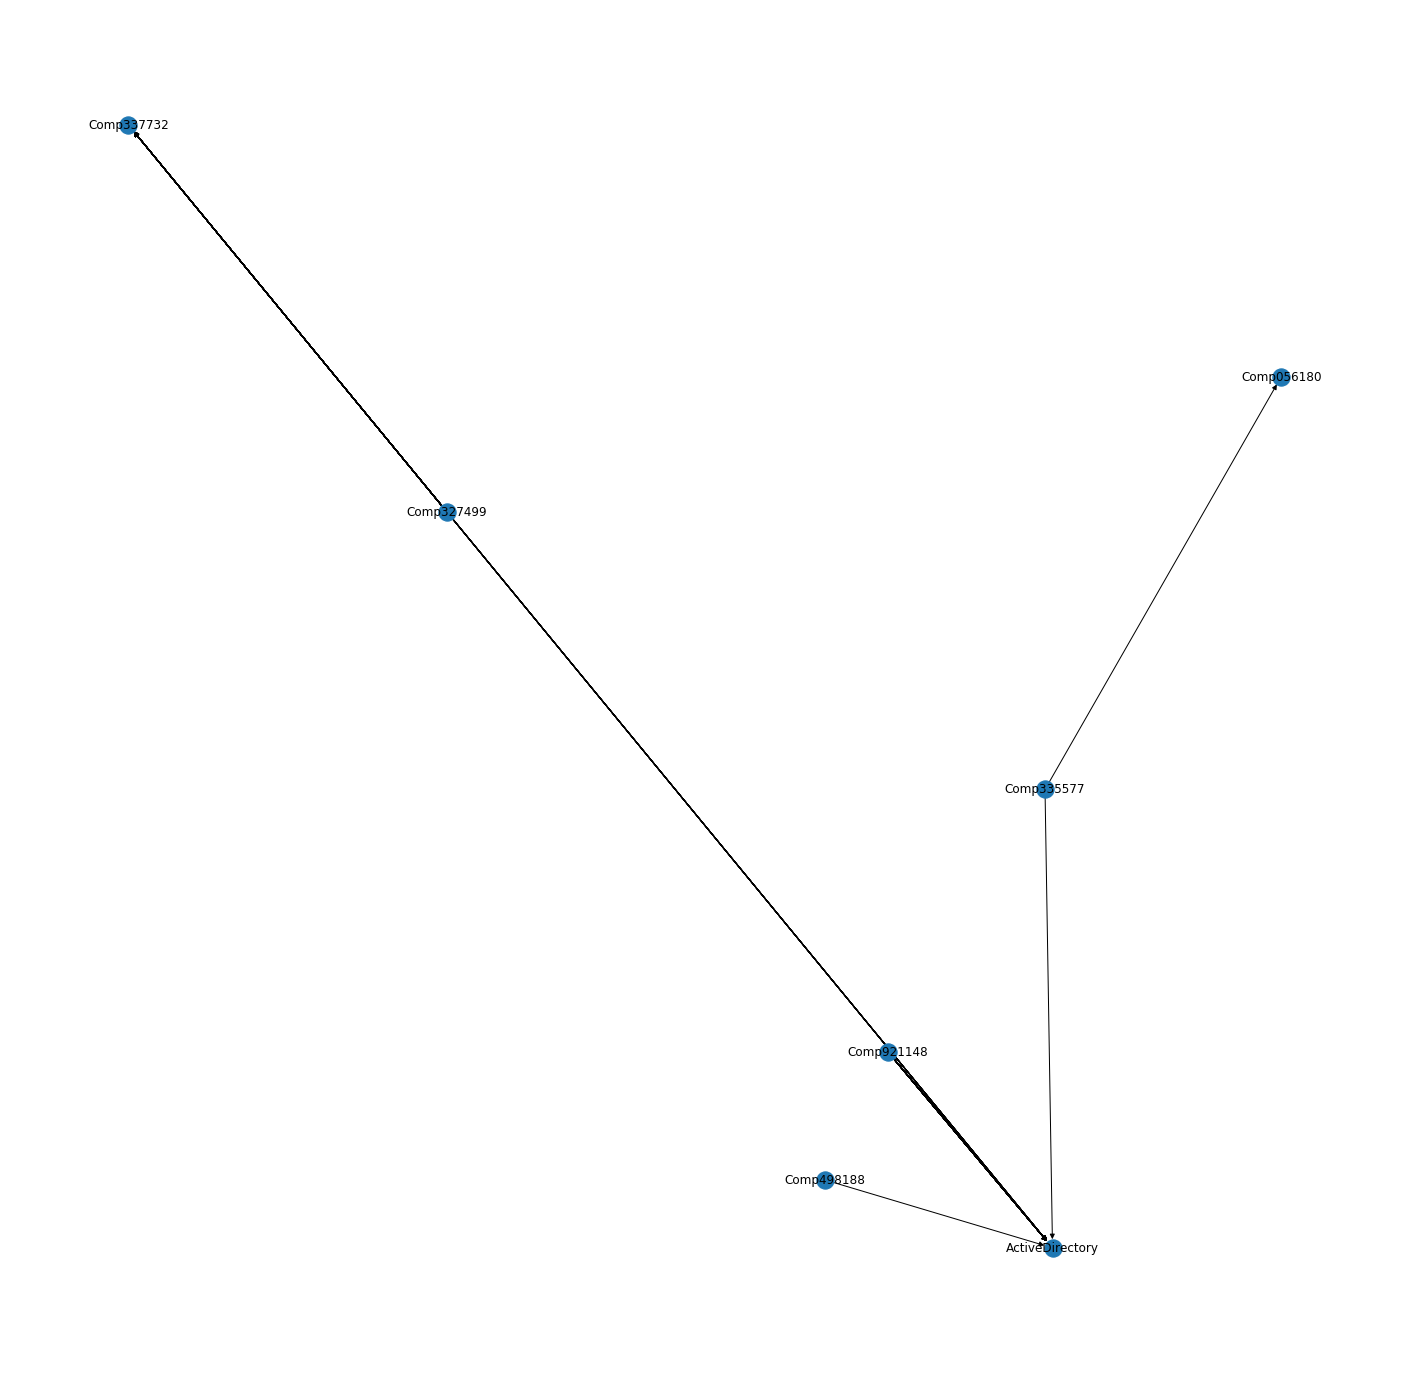

In [51]:
plt.figure(figsize=(25, 25))
layout = nx.spring_layout(G,iterations=50)
plt.axis('off')
nx.draw(G,pos=layout )
nx.draw_networkx_labels(G,pos=layout)
#nx.draw_networkx_edge_labels(G,pos=layout)
plt.draw()